# Decision Tree

In [18]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform
from sklearn.tree import plot_tree
from scipy.stats import randint

In [2]:
import sys
import os

sys.path.append(os.path.abspath(".."))

from utils import load_and_prepare_data, evaluate_metrics, plot_roc_curve, optimize_threshold

In [3]:
df = pd.read_parquet("../diabetes_dataset_prepared.parquet")
X_train, X_test, y_train, y_test = load_and_prepare_data(df)

We will begin with a simple decision tree, in order to plot it and get a general grasp of what to expect.

In [4]:
dt = DecisionTreeClassifier(max_depth=3)

dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


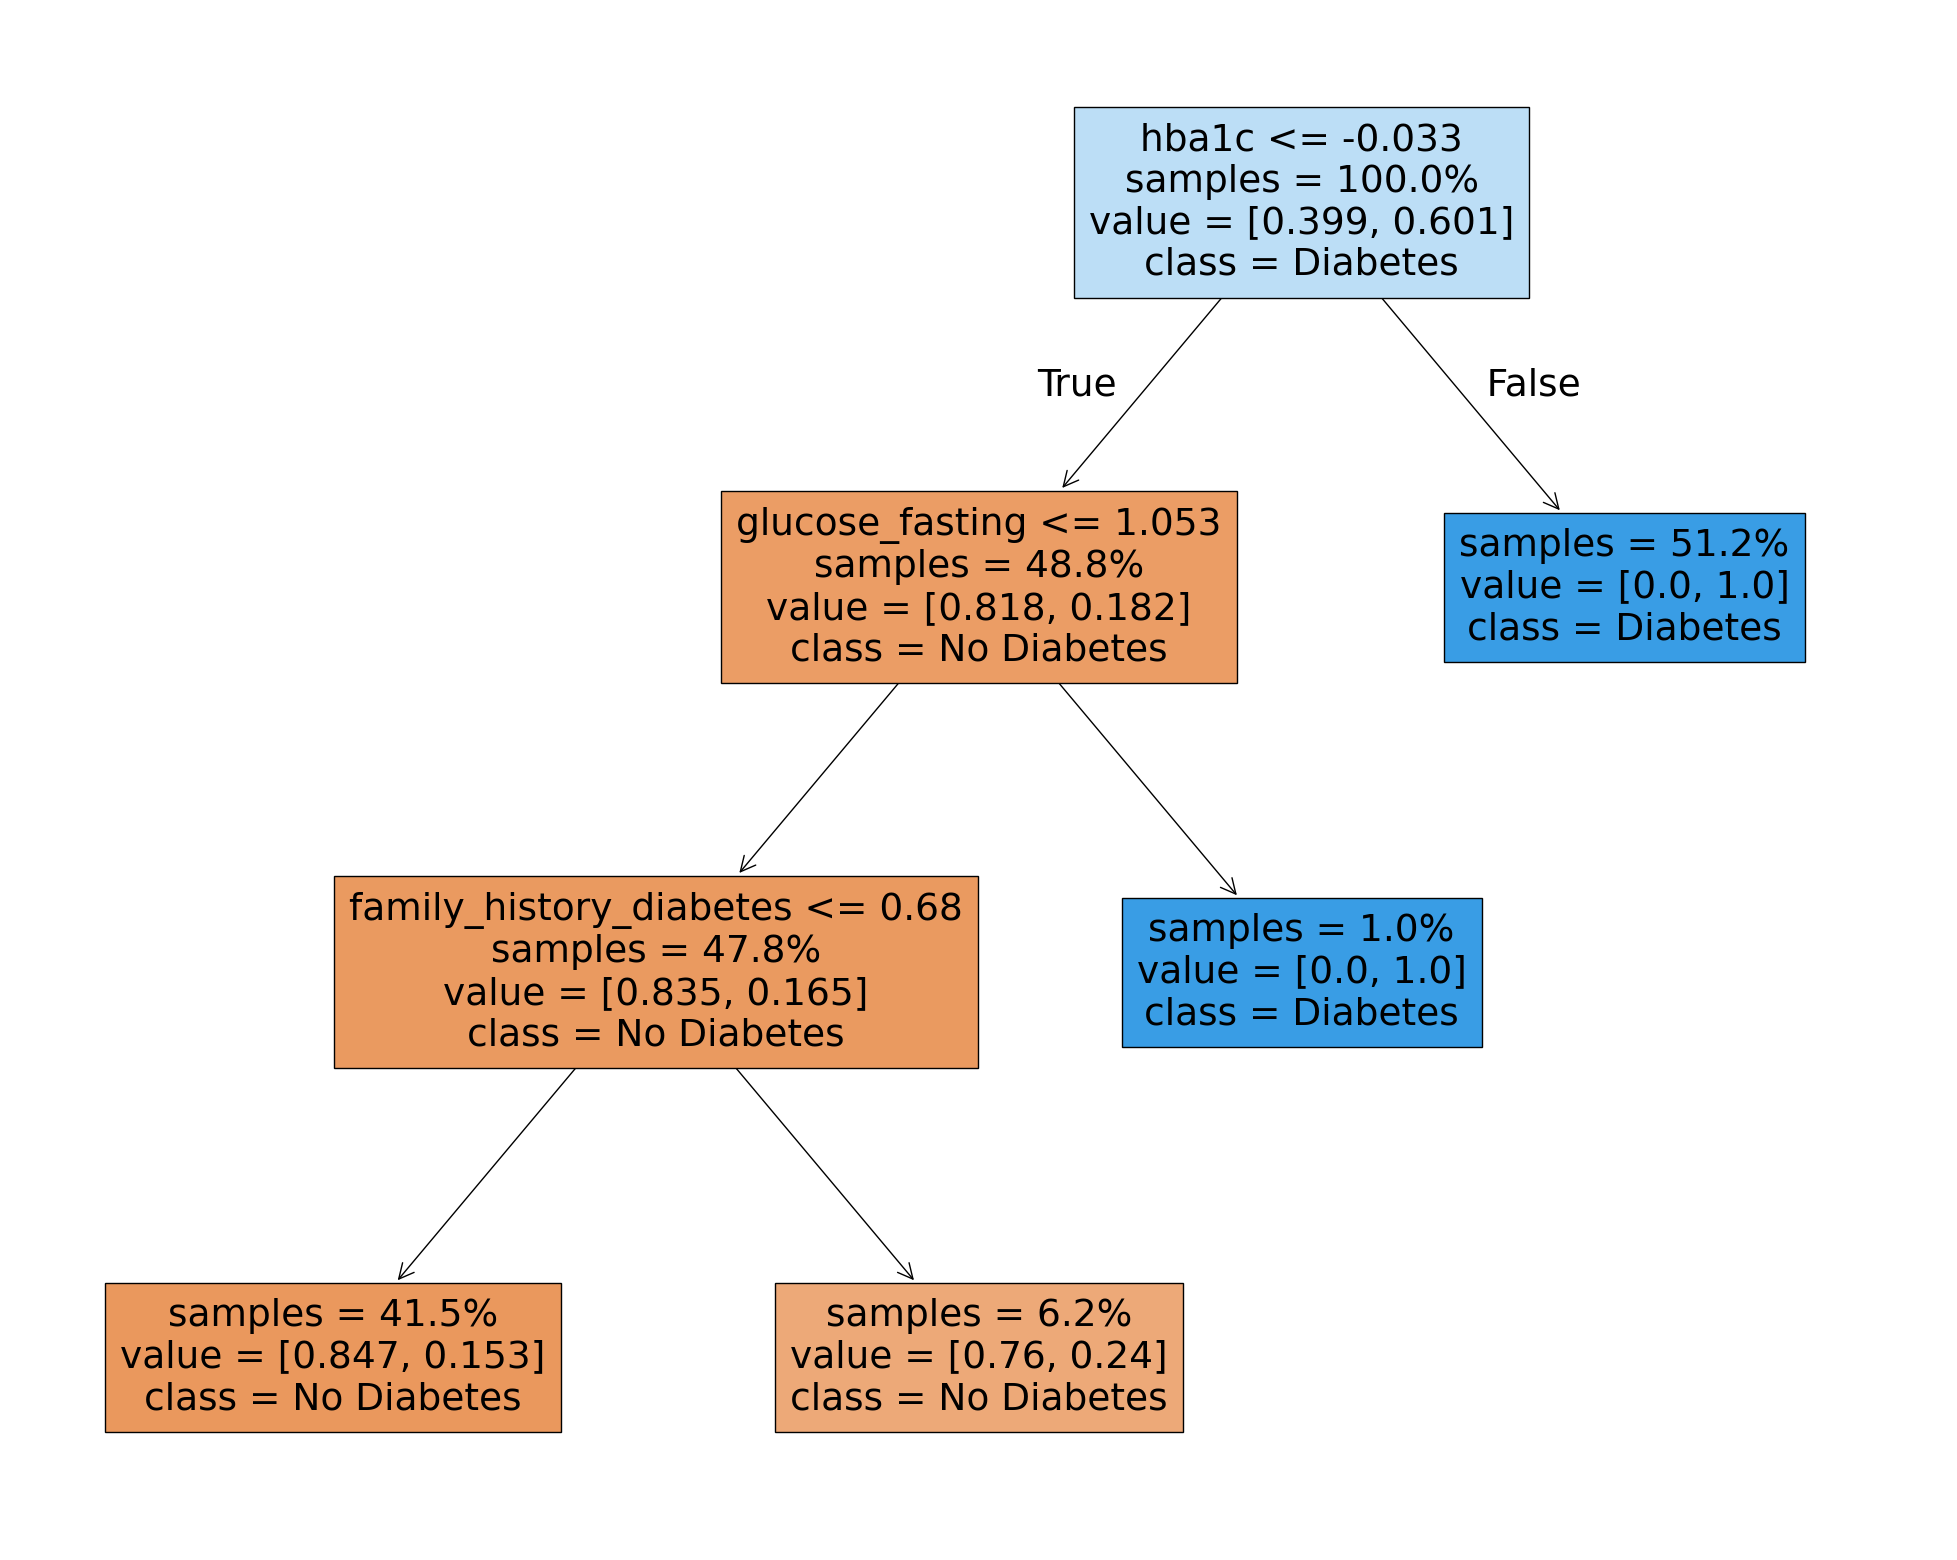

In [11]:
fig = plt.figure(figsize=(25, 20))

plot_tree(
    dt,
    feature_names=list(df.drop(["diagnosed_diabetes"], axis=1).columns),
    class_names=["No Diabetes", "Diabetes"],
    impurity=False,
    proportion=True,
    filled=True
);

In [17]:
importance_df = (
    pd.DataFrame({
        "feature": df.drop(["diagnosed_diabetes"], axis=1).columns, 
        "importance": dt.feature_importances_
    })
    .sort_values("importance", ascending=False)
)

importance_df.head(5)

,feature,importance
6,hba1c,0.958879
4,glucose_fasting,0.038782
0,family_history_diabetes,0.002339
46,screen_time_hours_per_day_Moderate,0.000000
52,bmi_Obese_II,0.000000


The most important factors appear to be hba1c, glucose_fasting, and family_history_diabetes. Apart from the absence of glucose_postprandial, this is not surprising. It is exactly what we would expect. We will quickly test the performance of this model now.

In [12]:
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

Training Set Metrics:


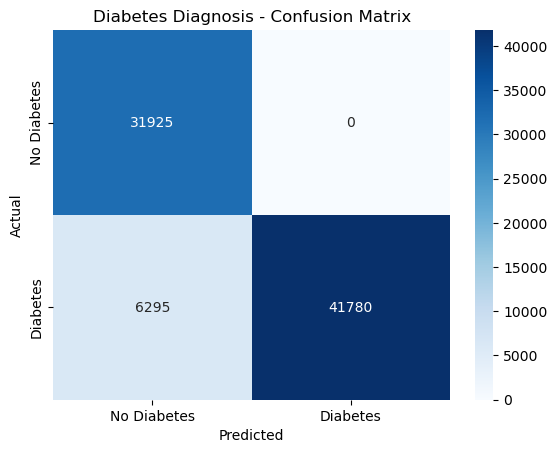

Accuracy: 0.9213125
Precision: 1.0
Recall: 0.8690587623504941
F1 Score: 0.9299426854376496


Test Set Metrics:


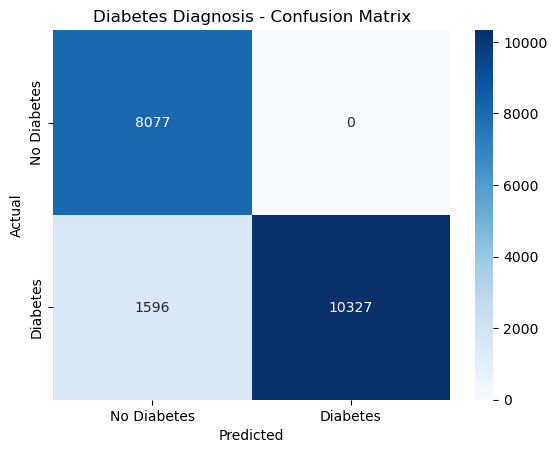

Accuracy: 0.9202
Precision: 1.0
Recall: 0.866141071877883
F1 Score: 0.9282696629213483


In [13]:
evaluate_metrics(y_train, y_train_pred, "Training Set Metrics:")

print("\n" + "="*75 + "\n")

evaluate_metrics(y_test, y_test_pred, "Test Set Metrics:")

A simple decision tree with no hyperparameter tuning already outperforms our knn and logistic regression models. This is also the first model that has perfect precision. Now we will try to find some better hyperparameters.

In [19]:
params = {
    "max_depth": randint(5, 30),
    "min_samples_split": randint(2, 50),
    "min_samples_leaf": randint(1, 20),
    "max_features": ["sqrt", "log2", None],
    "criterion": ["gini", "entropy"]
}

random_search = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_distributions=params,
    n_iter=50,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search.fit(X_train, y_train)

max_depth = random_search.best_params_["max_depth"]
min_samples_split = random_search.best_params_["min_samples_split"]
min_samples_leaf = random_search.best_params_["min_samples_leaf"]
max_features = random_search.best_params_["max_features"]
criterion = random_search.best_params_["criterion"]

random_search.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


{'criterion': 'entropy',
 'max_depth': 5,
 'max_features': None,
 'min_samples_leaf': 11,
 'min_samples_split': 18}

In [20]:
dt2 = DecisionTreeClassifier(
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    max_features=max_features,
    criterion=criterion,
    random_state=42
)

dt2.fit(X_train, y_train)

,criterion,'entropy'
,splitter,'best'
,max_depth,5
,min_samples_split,18
,min_samples_leaf,11
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [21]:
y_train_pred = dt2.predict(X_train)
y_test_pred = dt2.predict(X_test)

Training Set Metrics:


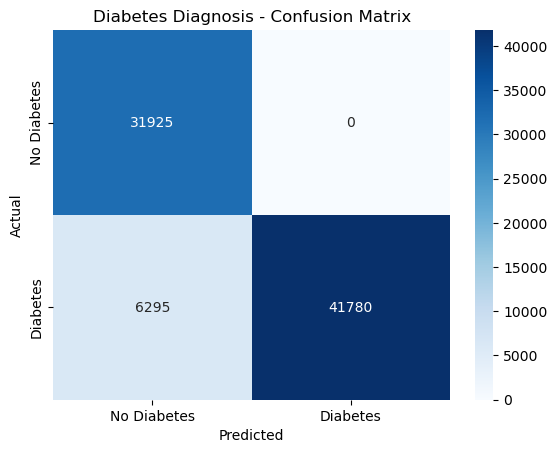

Accuracy: 0.9213125
Precision: 1.0
Recall: 0.8690587623504941
F1 Score: 0.9299426854376496


Test Set Metrics:


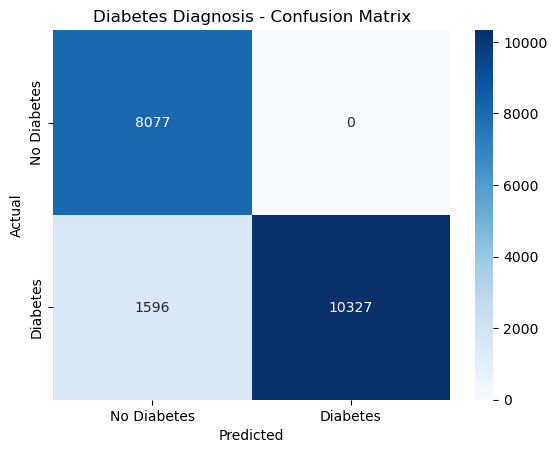

Accuracy: 0.9202
Precision: 1.0
Recall: 0.866141071877883
F1 Score: 0.9282696629213483


In [22]:
evaluate_metrics(y_train, y_train_pred, "Training Set Metrics:")

print("\n" + "="*75 + "\n")

evaluate_metrics(y_test, y_test_pred, "Test Set Metrics:")

This is no better than the initial tree model. We will keep searching for better hyperparameters.

In [23]:
params = {
    "max_depth": randint(2, 9),
    "min_samples_split": randint(14, 24),
    "min_samples_leaf": randint(5, 17),
    "max_features": [None],
    "criterion": ["entropy"]
}

random_search = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_distributions=params,
    n_iter=250,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search.fit(X_train, y_train)

max_depth = random_search.best_params_["max_depth"]
min_samples_split = random_search.best_params_["min_samples_split"]
min_samples_leaf = random_search.best_params_["min_samples_leaf"]
max_features = random_search.best_params_["max_features"]
criterion = random_search.best_params_["criterion"]

random_search.best_params_

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


{'criterion': 'entropy',
 'max_depth': 3,
 'max_features': None,
 'min_samples_leaf': 7,
 'min_samples_split': 20}

In [24]:
dt3 = DecisionTreeClassifier(
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    max_features=max_features,
    criterion=criterion,
    random_state=42
)

dt3.fit(X_train, y_train)

,criterion,'entropy'
,splitter,'best'
,max_depth,3
,min_samples_split,20
,min_samples_leaf,7
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [25]:
y_train_pred = dt3.predict(X_train)
y_test_pred = dt3.predict(X_test)

Training Set Metrics:


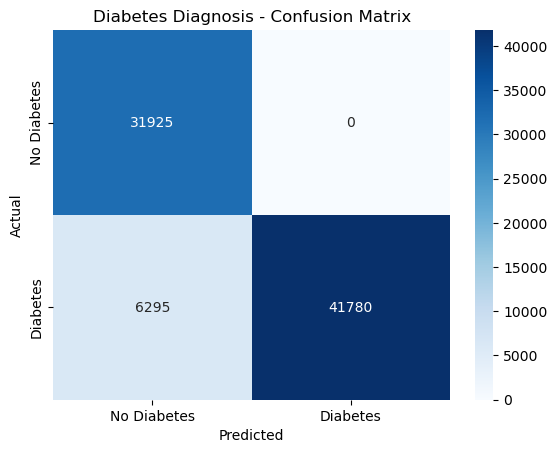

Accuracy: 0.9213125
Precision: 1.0
Recall: 0.8690587623504941
F1 Score: 0.9299426854376496


Test Set Metrics:


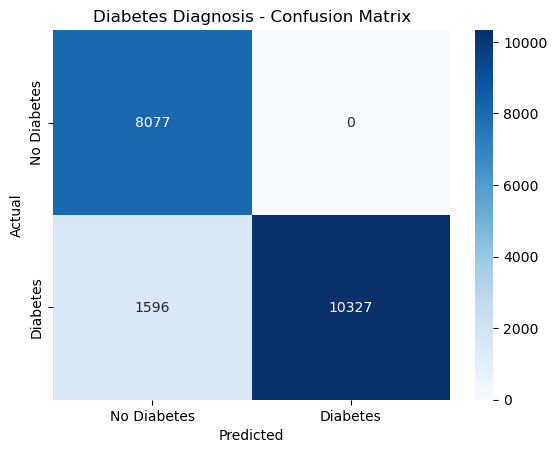

Accuracy: 0.9202
Precision: 1.0
Recall: 0.866141071877883
F1 Score: 0.9282696629213483


In [26]:
evaluate_metrics(y_train, y_train_pred, "Training Set Metrics:")

print("\n" + "="*75 + "\n")

evaluate_metrics(y_test, y_test_pred, "Test Set Metrics:")

Again, there is no improvement. We will attempt a final grid search.

In [27]:
params = {
    "max_depth": [2, 3, 4, 5, 6],
    "min_samples_split": [16, 17, 18, 19, 20, 21, 22],
    "min_samples_leaf": [6, 7, 8, 9, 10, 11, 12],
    "max_features": [None],
    "criterion": ["entropy"]
}

grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=params,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

max_depth = grid_search.best_params_["max_depth"]
min_samples_split = grid_search.best_params_["min_samples_split"]
min_samples_leaf = grid_search.best_params_["min_samples_leaf"]
max_features = grid_search.best_params_["max_features"]
criterion = grid_search.best_params_["criterion"]

grid_search.best_params_

Fitting 5 folds for each of 245 candidates, totalling 1225 fits


{'criterion': 'entropy',
 'max_depth': 2,
 'max_features': None,
 'min_samples_leaf': 6,
 'min_samples_split': 16}

In [28]:
dt4 = DecisionTreeClassifier(
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    max_features=max_features,
    criterion=criterion,
    random_state=42
)

dt4.fit(X_train, y_train)

,criterion,'entropy'
,splitter,'best'
,max_depth,2
,min_samples_split,16
,min_samples_leaf,6
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [29]:
y_train_pred = dt4.predict(X_train)
y_test_pred = dt4.predict(X_test)

Training Set Metrics:


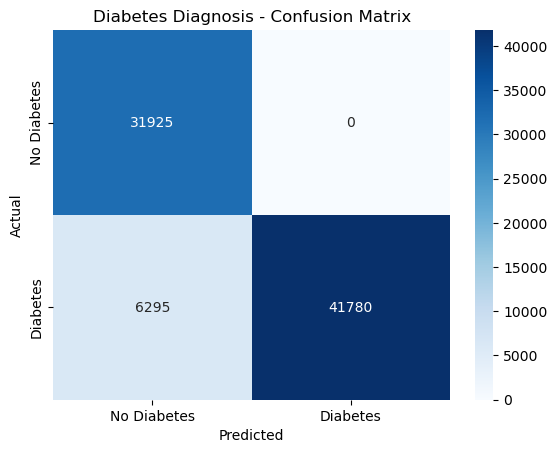

Accuracy: 0.9213125
Precision: 1.0
Recall: 0.8690587623504941
F1 Score: 0.9299426854376496


Test Set Metrics:


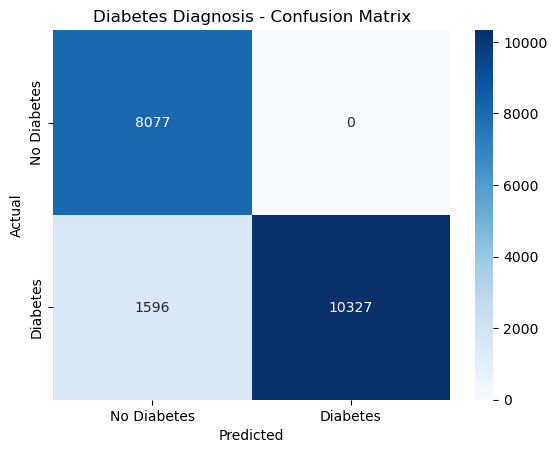

Accuracy: 0.9202
Precision: 1.0
Recall: 0.866141071877883
F1 Score: 0.9282696629213483


In [30]:
evaluate_metrics(y_train, y_train_pred, "Training Set Metrics:")

print("\n" + "="*75 + "\n")

evaluate_metrics(y_test, y_test_pred, "Test Set Metrics:")

No improvement. Let us try to optimize the threshold for f1.

In [31]:
y_train_pred_proba = dt4.predict_proba(X_train)
y_test_pred_proba = dt4.predict_proba(X_test)

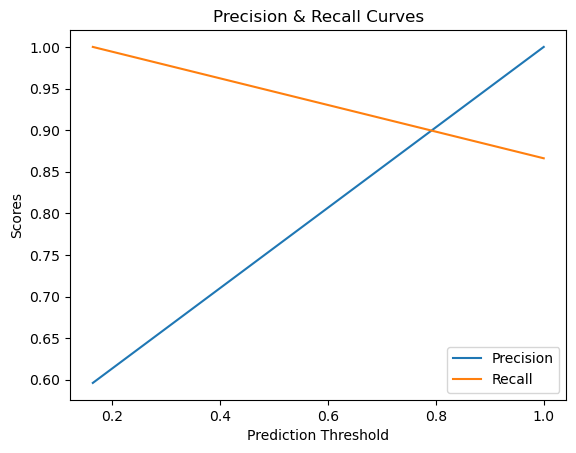

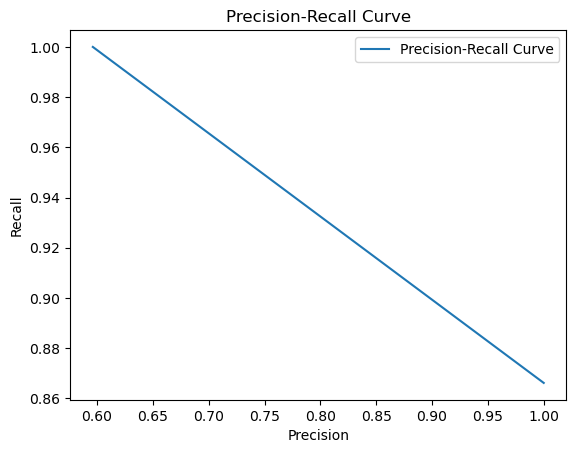

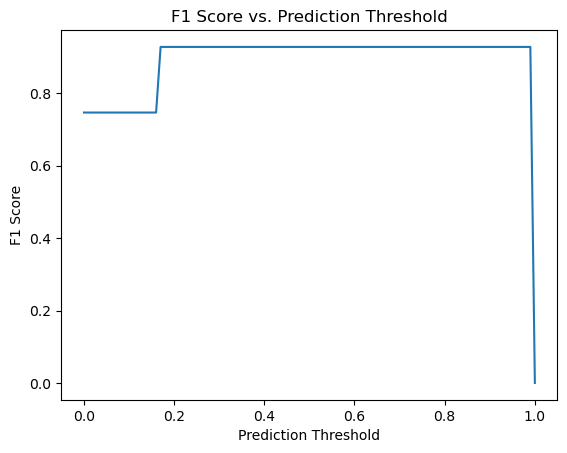

Optimal threshold: 0.17


In [32]:
thresh = optimize_threshold(y_test, y_test_pred_proba[:, 1])
print(f"Optimal threshold: {thresh}")

In [37]:
preds_train = y_train_pred_proba[:, 1] >= thresh
preds_test = y_test_pred_proba[:, 1] >= thresh

Training Set Metrics with Optimized Threshold:


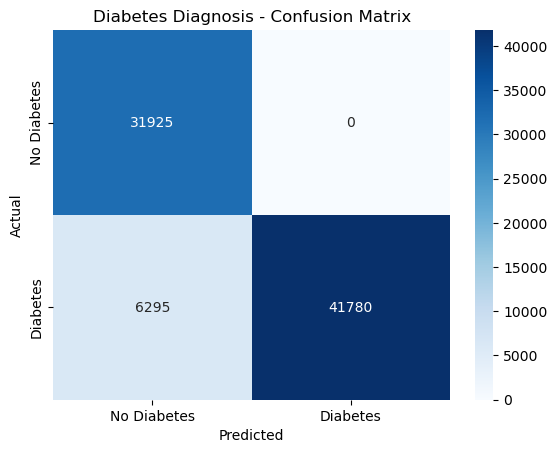

Accuracy: 0.9213125
Precision: 1.0
Recall: 0.8690587623504941
F1 Score: 0.9299426854376496


Test Set Metrics with Optimized Threshold:


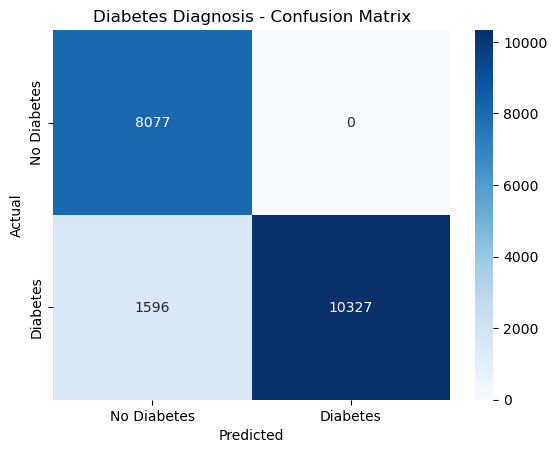

Accuracy: 0.9202
Precision: 1.0
Recall: 0.866141071877883
F1 Score: 0.9282696629213483


In [38]:
evaluate_metrics(y_train, preds_train, "Training Set Metrics with Optimized Threshold:")

print("\n" + "="*75 + "\n")

evaluate_metrics(y_test, preds_test, "Test Set Metrics with Optimized Threshold:")

No improvement. Still, the model performs reasonably well. We will take another look at feature importances.

In [40]:
importance_df = (
    pd.DataFrame({
        "feature": df.drop(["diagnosed_diabetes"], axis=1).columns, 
        "importance": dt4.feature_importances_
    })
    .sort_values("importance", ascending=False)
)

importance_df.head(10)

,feature,importance
6,hba1c,0.962171
4,glucose_fasting,0.037829
0,family_history_diabetes,0.000000
46,screen_time_hours_per_day_Moderate,0.000000
52,bmi_Obese_II,0.000000
51,bmi_Obese_I,0.000000
50,bmi_Overweight,0.000000
49,bmi_Normal,0.000000
48,screen_time_hours_per_day_Very_High,0.000000
47,screen_time_hours_per_day_High,0.000000


One feature dominates the rest, clearly. Let us see what the roc curve looks like.

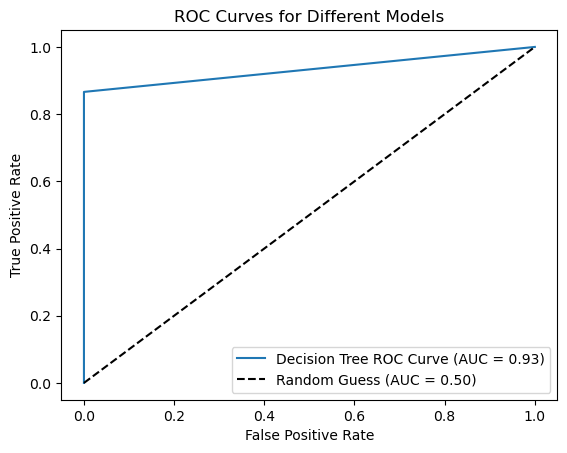

In [41]:
plot_roc_curve(y_test, y_test_pred_proba[:, 1], "Decision Tree ROC Curve")

AUC has not improved, compared to knn and logistic regression. We will save the model.

In [42]:
joblib.dump(dt4, "../models/decision_tree_model.joblib")

['../models/decision_tree_model.joblib']